In [215]:
## Packages to Import

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from interpret.glassbox import ExplainableBoostingClassifier
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from interpret import show

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, balanced_accuracy_score, matthews_corrcoef, f1_score, silhouette_score

# !pip install nbformat
# !pip install plotly==5.10.0
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.io as pio
pio.renderers.default = "colab"

# Question 1

In [216]:
# read the dataset
df=pd.read_csv("hypotension_patients.csv")

# save the patient IDs
patients = df['ID']

# remove ID
df = df.drop(columns=['ID'])
df.head()

,anchor_age,gender,dod,apsiii,LoS,charlson_comorbidity_index
0,80,F,NaN,56,7.00,4
1,72,F,2137-09-02,49,12.92,6
2,82,M,2144-06-18,46,13.13,5
3,89,F,2155-12-07,86,4.92,7
4,69,F,2136-05-12,102,11.46,8


## Summary Statistics

In [217]:
# Convert the dod into categorical
df['dod'] = df['dod'].apply(lambda x: 1 if pd.notna(x) else 0)

#save the patient dods
dod = df['dod']

# convert gender into categorical
categorical_gender = pd.get_dummies(df['gender'],drop_first=True)

# concat the categorical gender with the original dataset
final_df = pd.concat([df,categorical_gender],axis=1)

#save the gender
gender = final_df['gender']

final_df = final_df.drop(['gender'],axis=1)

print(final_df)

      anchor_age  dod  apsiii     LoS  charlson_comorbidity_index      M
0             80    0      56    7.00                           4  False
1             72    1      49   12.92                           6  False
2             82    1      46   13.13                           5   True
3             89    1      86    4.92                           7  False
4             69    1     102   11.46                           8  False
5             64    1      88    9.96                          10  False
6             60    0      50    2.54                           3  False
7             87    1      58    1.17                          10   True
8             63    0      35   39.83                           4   True
9             65    1      49    3.58                           5  False
10            72    1      50    9.08                          10   True
11            43    0      38   15.67                           1   True
12            65    1      36    0.67              

In [218]:
print(final_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5106 entries, 0 to 5105
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   anchor_age                  5106 non-null   int64  
 1   dod                         5106 non-null   int64  
 2   apsiii                      5106 non-null   int64  
 3   LoS                         5106 non-null   float64
 4   charlson_comorbidity_index  5106 non-null   int64  
 5   M                           5106 non-null   bool   
dtypes: bool(1), float64(1), int64(4)
memory usage: 204.6 KB
None


In [219]:
#obtain and show summary statistics
summary = final_df.describe(include='all')

summary

,anchor_age,dod,apsiii,LoS,charlson_comorbidity_index,M
count,5106.000000,5106.00000,5106.000000,5106.000000,5106.00000,5106
unique,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,True
freq,NaN,NaN,NaN,NaN,NaN,2853
mean,65.552683,0.64434,60.314532,7.053651,5.21700,NaN
std,15.235907,0.47876,28.860171,8.432716,2.57691,NaN
min,18.000000,0.00000,3.000000,0.040000,0.00000,NaN
25%,56.000000,0.00000,38.000000,1.960000,4.00000,NaN
50%,67.000000,1.00000,53.000000,4.130000,5.00000,NaN
75%,77.000000,1.00000,78.000000,8.960000,7.00000,NaN


In [220]:
# get death counts for all the patients
dod_counts = final_df['dod'].value_counts()

dod_counts

dod
1    3290
0    1816
Name: count, dtype: int64

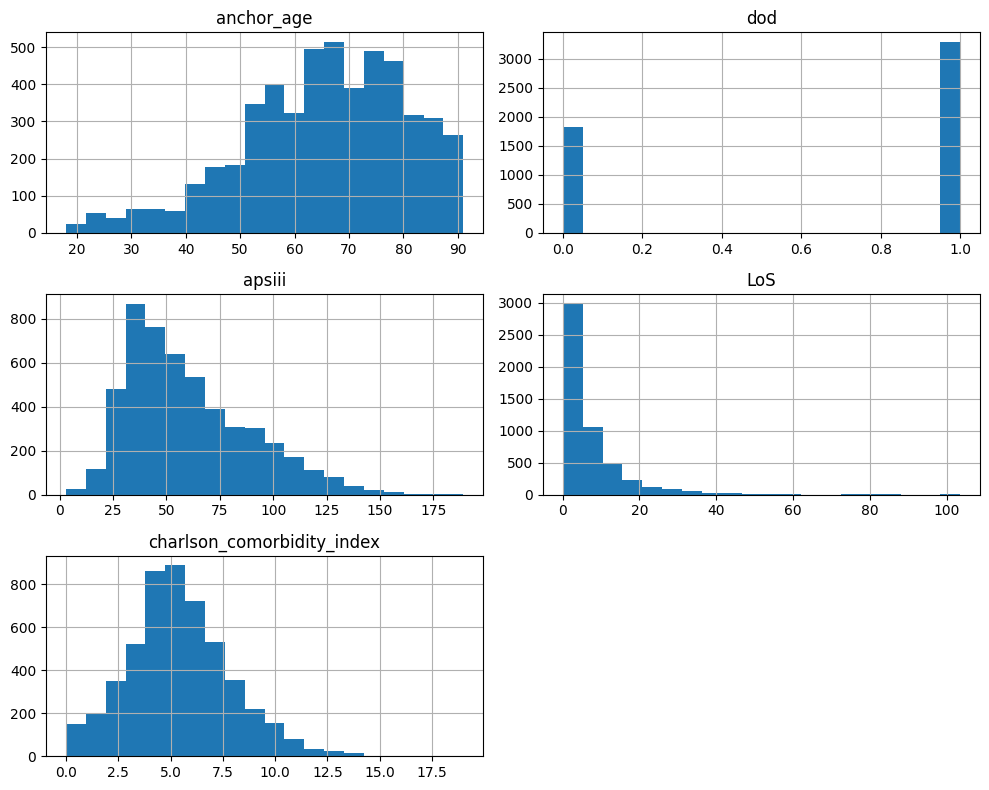

In [221]:
# visualize each feature 
final_df.hist(figsize=(10,8), bins=20)
plt.tight_layout()
plt.show()

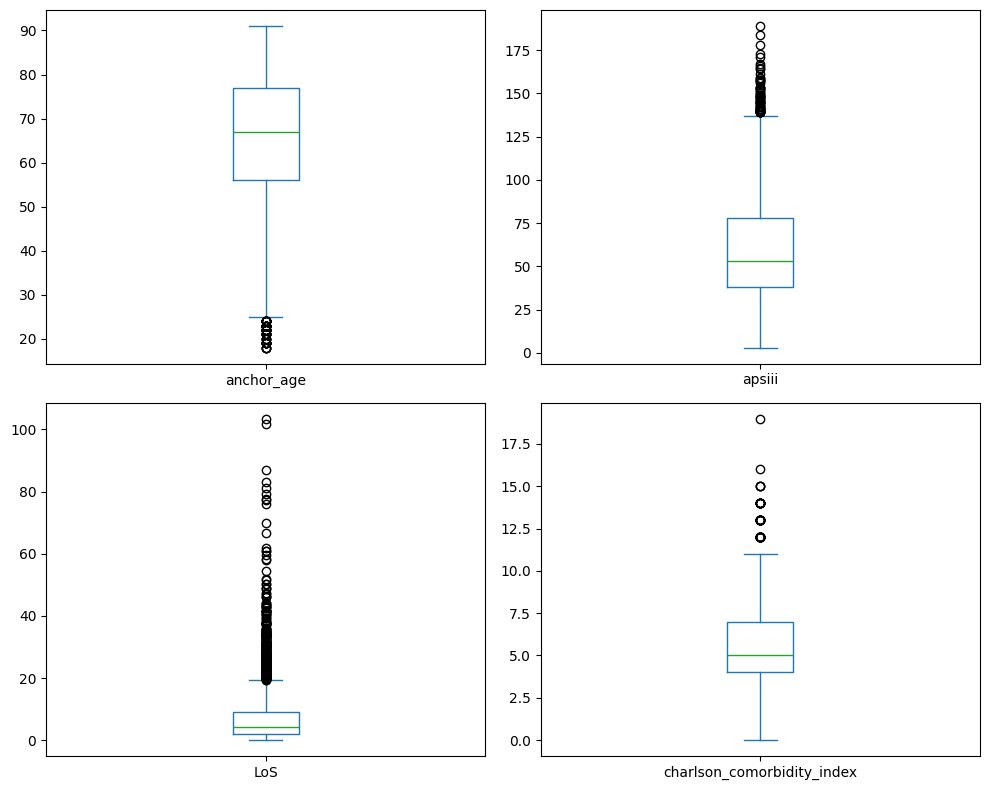

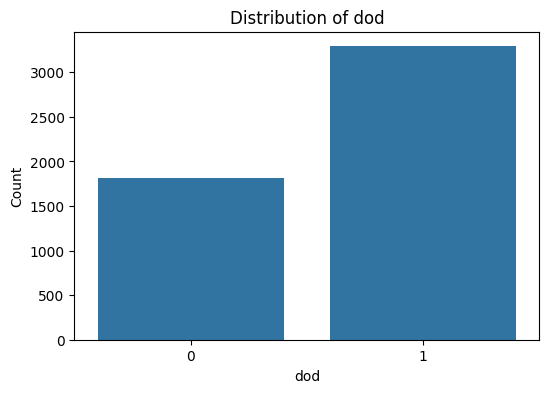

In [222]:
# Create boxplots for the other variables
final_df[['anchor_age', 'apsiii', 'LoS', 'charlson_comorbidity_index']].plot(kind='box', subplots=True, layout=(2, 2), figsize=(10, 8), sharex=False, sharey=False)
plt.tight_layout()

# Create a separate bar plot for patient outcomes for better visualization
plt.figure(figsize=(6, 4))
sns.countplot(x='dod', data=final_df)
plt.title('Distribution of dod')
plt.xlabel('dod')
plt.ylabel('Count')

# Show the plots
plt.show()

## EBM Visualization

In [223]:
# dod as final variable
X = final_df.drop('dod', axis=1)
y = final_df['dod'] 

# split with 10% as the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# train the ebm
ebm = ExplainableBoostingClassifier(random_state=1)
classifier = ebm.fit(X_train, y_train)

# Accuracy of model in training
print('Classifier Score in Training (Accuracy): ',classifier.score(X_train,y_train))

# Predict the test set
predictions = ebm.predict(X_test)

# Evaluate the model's accuracy, balanced accuracy, mcc, and F1 Score
acc = accuracy_score(y_test, predictions)

bacc = balanced_accuracy_score(y_test,predictions)

mcc = matthews_corrcoef(y_test, predictions)

f1 = f1_score(y_test, predictions)

# save the results
results = {'Accuracy' : [acc], 'Balanced Accuracy' : [bacc], 'MCC' : [mcc], 'F1-Score' : [f1]}

# save the results as a df
final_df_results = pd.DataFrame.from_dict(data=results,orient='columns')

print(final_df_results)


Classifier Score in Training (Accuracy):  0.6964091403699674
   Accuracy  Balanced Accuracy       MCC  F1-Score
0  0.661448           0.598388  0.240727  0.760719


In [224]:
# Visualize global model behaviour with each feature using EBM
ebm_global = ebm.explain_global()
show(ebm_global)


In [225]:
# Visualize model behaviour with unseen examples

set_visualize_provider(InlineProvider())
ebm_local = ebm.explain_local(X_test[:5], y_test[:5])
show(ebm_local)

## Answer to Question 1


The cohort contains 5106 patients with profound hypotension, with a mean age of 65.6 years, indicating an older population. 75% of patients are aged 56 or older. The mortality rate is also moderately high, with around 64% (3290) patients dying, showing the potential severity of the disease.

The Aspiii score is moderately right-skewed, with a mean of 60.3. Most patients are in this range, which can be considered as moderate to high severity. However, 25% of scores exceed 78, showing high severity. The outliers in the boxplot also show extreme levels, where some Aspiii scores can reach 189.

Length of stay (LoS) is also right-skewed. Most patients are discharged in about 7 days, with only 25% staying longer than 8.96 days. However, the boxplot suggests that some patients require much more significant long-term care(with a maximum of 103.5 days stay). The moderately high fatality of the disease might also contribute to why LoS is short, as most patients might have died within a few days of being hospitalized.

Finally, the Charlson Comorbidity Index shows that most patients have multiple comorbidities, with a mean score of 5.2%. A few outliers also reach 19, which could reflect a group of patients that are at much higher risks for negative outcomes from this disease.

# Question 2

## Elbow Criteria Plot

[5836389.843463063, 2847771.8694478082, 2231676.0022735135, 1800935.363355278, 1542550.9231715119, 1353420.5165622043, 1227981.7266072808, 1150869.001939207, 1052426.8382322341, 973428.7771029142]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


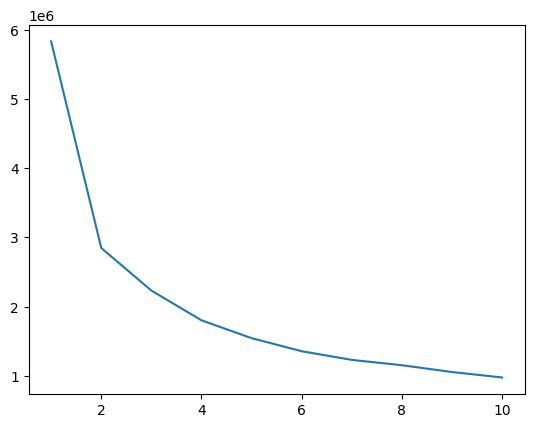

In [226]:
# deep copy the df for k-means
data_km = final_df.copy()

# calculate the intra-distance parameter
intradistance = []
for cluster_count in range (1,11):
    kmeans = KMeans(n_clusters = cluster_count, random_state = 0)
    kmeans.fit(data_km)
    intradistance.append(kmeans.inertia_)
print(intradistance)

## create the elbow plot
ks = [1,2,3,4,5,6,7,8,9,10]
print(ks)
plt.plot(ks, intradistance)

## K-Means Clustering (2 and 3 Clusters)

In [227]:
# Using 2 Clusters

data_km2=data_km.copy()

number_of_clusters = 2

kmeans2 = KMeans(n_clusters = number_of_clusters, random_state = 0)
kmeans2.fit(data_km2)

#Find which cluster each data-point belongs to
clusters = kmeans2.predict(data_km2)

#Add the cluster information as a new column to our DataFrame
data_km2["Cluster"] = clusters

print(data_km2.groupby(['Cluster']).sum())

         anchor_age   dod  apsiii       LoS  charlson_comorbidity_index     M
Cluster                                                                      
0            226943  1985  150876  20572.34                       17278  1950
1            107769  1305  157090  15443.60                        9360   903


In [228]:
silhouette_score(data_km2, data_km2['Cluster'])

0.46396869337149377

In [229]:
# Using 3 Clusters

data_km3=data_km.copy()

number_of_clusters = 3

kmeans3 = KMeans(n_clusters = number_of_clusters, random_state = 0)
kmeans3.fit(data_km3)

#Find which cluster each data-point belongs to
clusters = kmeans3.predict(data_km3)

#Add the cluster information as a new column to our DataFrame
data_km3["Cluster"] = clusters

print(data_km3.groupby(['Cluster']).sum())

         anchor_age   dod  apsiii       LoS  charlson_comorbidity_index     M
Cluster                                                                      
0            147570  1231   83677  12039.45                       10880  1324
1             65342   842  109136  10351.25                        5729   561
2            121800  1217  115153  13625.24                       10029   968


In [230]:
silhouette_score(data_km3, data_km3['Cluster'])

0.313640238531275

## Plotting the K-Means Using PCA and Boxplots For Cluster 2

In [231]:
#choose between data_km2 or data_km3 for different clusters

chosen_cluster = data_km2
plotX = chosen_cluster

#PCA with 2 principal components for a 2-D visualisation:
pca_2d = PCA(n_components=2)

#And this DataFrame contains 2 principal components that will aid us
#in visualizing our clusters in
PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotX.drop(["Cluster"], axis=1)))
PCs_2d.columns = ["PC1_2d", "PC2_2d"]


#We concatenate these newly created DataFrames to plotX so that they can be used by plotX as columns.
plotX = pd.concat([plotX,PCs_2d], axis=1, join='inner')

#Now we divide plotX into 2 new DataFrames.
#Each of these new DataFrames will hold all of the values contained in exacltly one of the clusters.
cluster0 = plotX[plotX["Cluster"] == 0]
cluster1 = plotX[plotX["Cluster"] == 1]

# ADDED IF A 3RD CLUSTER IS DESIRED
cluster2 = plotX[plotX["Cluster"] == 2]


## Calculate the mean value (Centroids) for each cluster to be seen in the Plot Figure:

centr = [[cluster0["PC1_2d"].mean(), cluster0["PC2_2d"].mean()],
         [cluster1["PC1_2d"].mean(), cluster1["PC2_2d"].mean()]]

centr_x = [x for x,y in centr]
centr_y = [y for x,y in centr]

In [232]:
def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
  init_notebook_mode(connected=True)

#This is needed so we can display plotly plots properly
# init_notebook_mode(connected=True) #If you are running it locally as a jupyter notebook
enable_plotly_in_cell() #If you are running it in Google Colab as a jupyter notebook

#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["PC1_2d"],
                    y = cluster0["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["PC1_2d"],
                    y = cluster1["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

# Include the centroids
centroids = go.Scatter(x = centr_x,
                       y = centr_y,
                      mode = "markers",
                      name = 'centroids',
                      marker = dict(color = 'black'),
                      text = None)

data = [trace1, trace2, centroids]

# ADDED IF A 3RD CLUSTER IS DESIRED
data = [trace1, trace2, trace3, centroids]

title = "Visualizing Clusters in 2 Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

# Plot the data:
fig = dict(data = data, layout = layout)
iplot(fig)


<Figure size 1000x600 with 0 Axes>

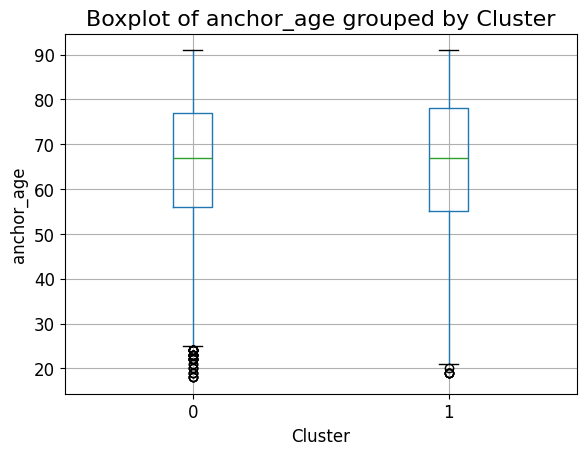

<Figure size 1000x600 with 0 Axes>

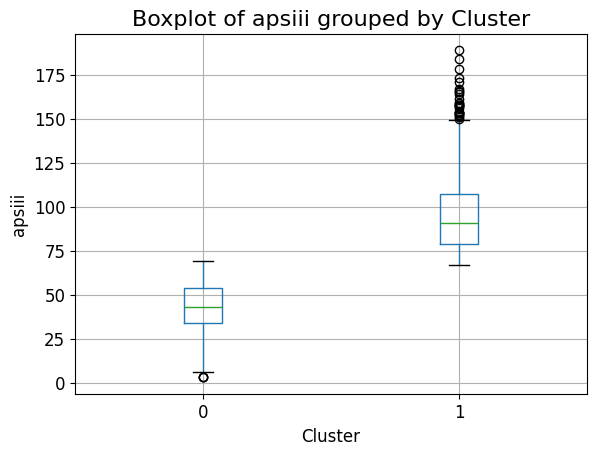

<Figure size 1000x600 with 0 Axes>

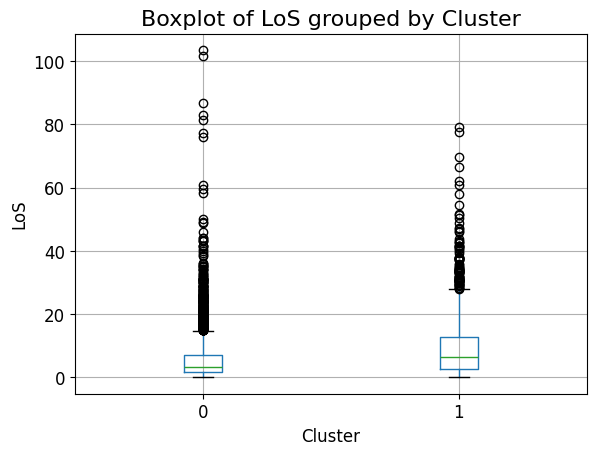

<Figure size 1000x600 with 0 Axes>

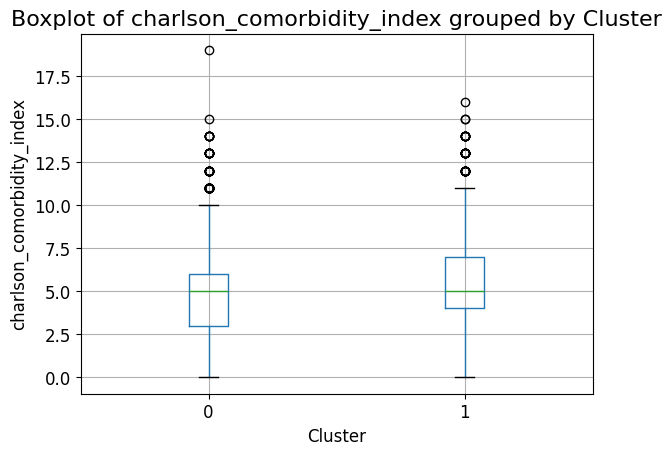

In [233]:
# list of variables to plot with boxplots
variables = ['anchor_age', 'apsiii', 'LoS', 'charlson_comorbidity_index']

for var in variables:
    plt.figure(figsize=(10, 6))
    chosen_cluster.boxplot(column=var, by='Cluster')
    
    plt.title(f'Boxplot of {var} grouped by Cluster', fontsize=16)
    plt.suptitle('')
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel(var, fontsize=12)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

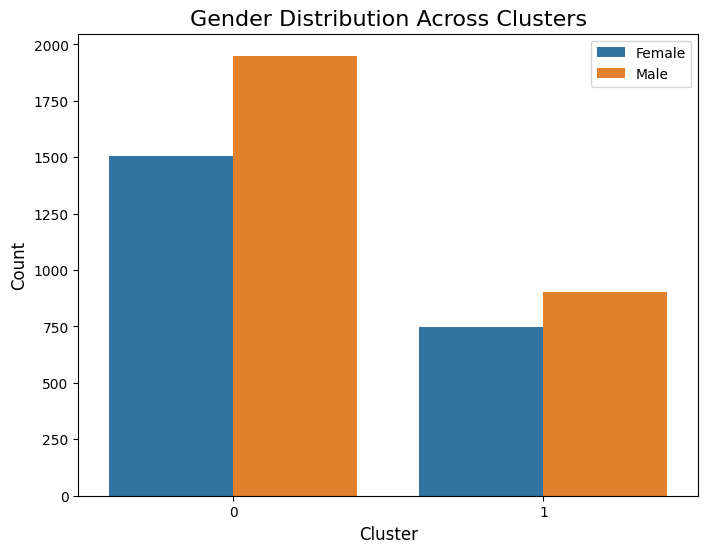

In [234]:
# bar plot for gender
plt.figure(figsize=(8, 6))
sns.countplot(x='Cluster', hue='M', data=chosen_cluster)

plt.title('Gender Distribution Across Clusters', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.legend(labels=['Female','Male'])
plt.show()

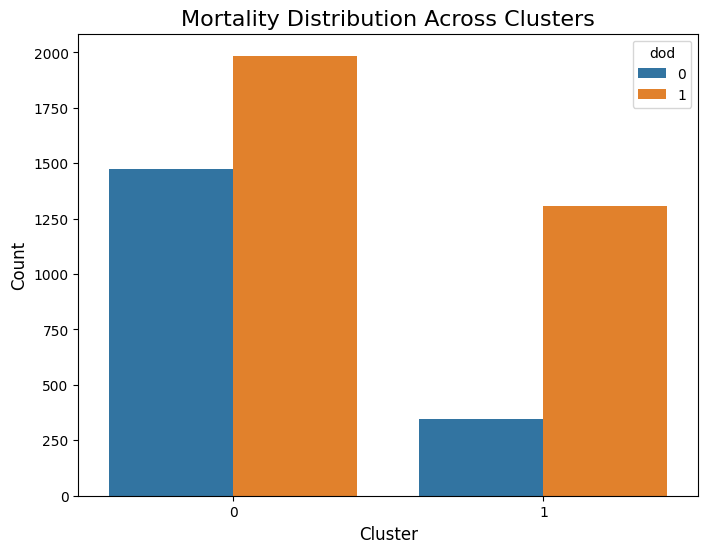

In [235]:
# bar plot for mortality rates
plt.figure(figsize=(8, 6))
sns.countplot(x='Cluster', hue='dod', data=chosen_cluster)

plt.title('Mortality Distribution Across Clusters', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

## Plotting the K-Means Using PCA and Boxplots For Cluster 3

In [236]:
#choose between data_km2 or data_km3 for different clusters

chosen_cluster = data_km3
plotX = chosen_cluster

#PCA with 2 principal components for a 2-D visualisation:
pca_2d = PCA(n_components=2)

#And this DataFrame contains 2 principal components that will aid us
#in visualizing our clusters in
PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotX.drop(["Cluster"], axis=1)))
PCs_2d.columns = ["PC1_2d", "PC2_2d"]


#We concatenate these newly created DataFrames to plotX so that they can be used by plotX as columns.
plotX = pd.concat([plotX,PCs_2d], axis=1, join='inner')

#Now we divide plotX into 2 new DataFrames.
#Each of these new DataFrames will hold all of the values contained in exacltly one of the clusters.
cluster0 = plotX[plotX["Cluster"] == 0]
cluster1 = plotX[plotX["Cluster"] == 1]

# ADDED IF A 3RD CLUSTER IS DESIRED
cluster2 = plotX[plotX["Cluster"] == 2]


## Calculate the mean value (Centroids) for each cluster to be seen in the Plot Figure:

centr = [[cluster0["PC1_2d"].mean(), cluster0["PC2_2d"].mean()],
         [cluster1["PC1_2d"].mean(), cluster1["PC2_2d"].mean()]]

# ADDED IF A 3RD CLUSTER IS DESIRED
centr = [
        [cluster0["PC1_2d"].mean(), cluster0["PC2_2d"].mean()],
         [cluster1["PC1_2d"].mean(), cluster1["PC2_2d"].mean()],
         [cluster2["PC1_2d"].mean(), cluster2["PC2_2d"].mean()]
         ]

centr_x = [x for x,y in centr]
centr_y = [y for x,y in centr]

In [237]:
def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
  init_notebook_mode(connected=True)

#This is needed so we can display plotly plots properly
# init_notebook_mode(connected=True) #If you are running it locally as a jupyter notebook
enable_plotly_in_cell() #If you are running it in Google Colab as a jupyter notebook

#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["PC1_2d"],
                    y = cluster0["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["PC1_2d"],
                    y = cluster1["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

# ADDED IF A 3RD CLUSTER IS DESIRED
trace3 = go.Scatter(
    x = cluster2["PC1_2d"],
    y = cluster2["PC2_2d"],
    mode = "markers",
    name = "Cluster 2",
    marker = dict(color = 'rgba(0, 255, 128, 0.8)'),  # New color for Cluster 2
    text = None
)

# Include the centroids
centroids = go.Scatter(x = centr_x,
                       y = centr_y,
                      mode = "markers",
                      name = 'centroids',
                      marker = dict(color = 'black'),
                      text = None)

data = [trace1, trace2, centroids]

# ADDED IF A 3RD CLUSTER IS DESIRED
data = [trace1, trace2, trace3, centroids]

title = "Visualizing Clusters in 2 Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

# Plot the data:
fig = dict(data = data, layout = layout)
iplot(fig)


<Figure size 1000x600 with 0 Axes>

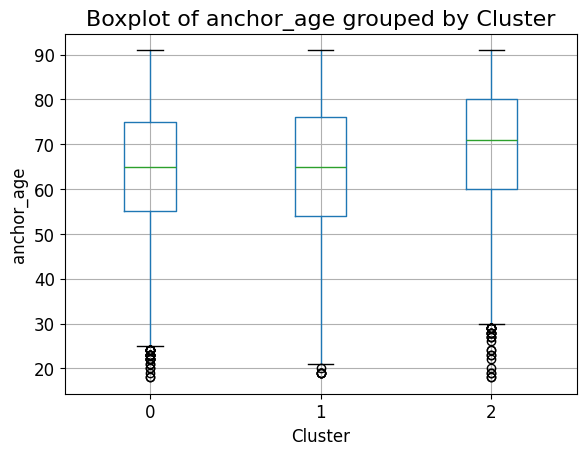

<Figure size 1000x600 with 0 Axes>

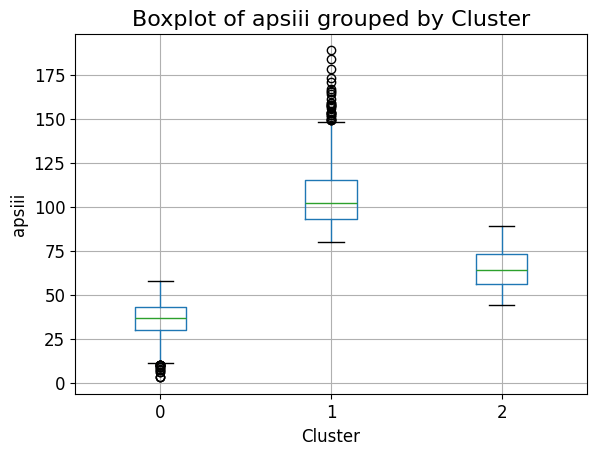

<Figure size 1000x600 with 0 Axes>

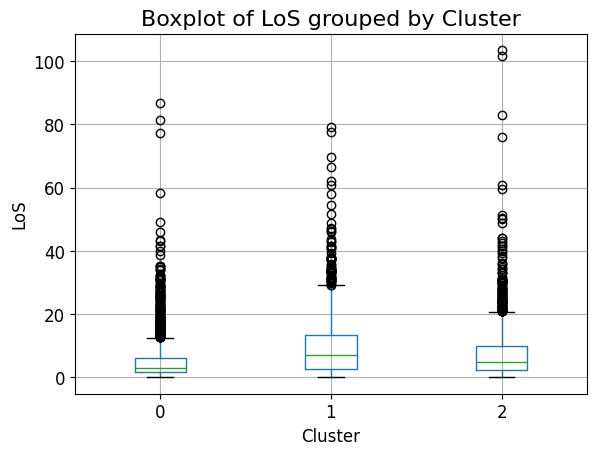

<Figure size 1000x600 with 0 Axes>

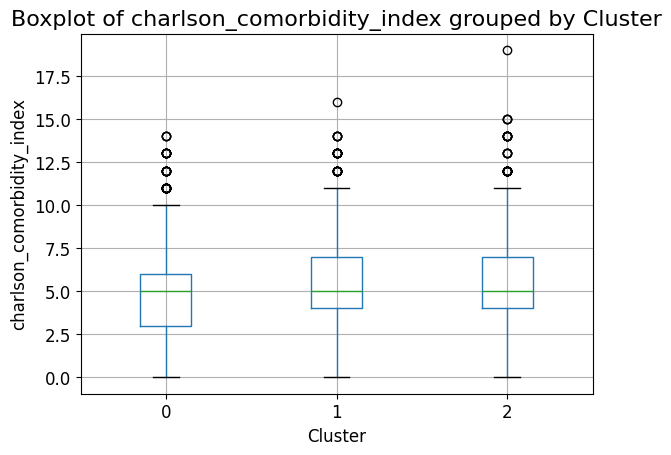

In [238]:
# list of variables to plot with boxplots
variables = ['anchor_age', 'apsiii', 'LoS', 'charlson_comorbidity_index']

for var in variables:
    plt.figure(figsize=(10, 6))
    chosen_cluster.boxplot(column=var, by='Cluster')
    
    plt.title(f'Boxplot of {var} grouped by Cluster', fontsize=16)
    plt.suptitle('')
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel(var, fontsize=12)
    

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

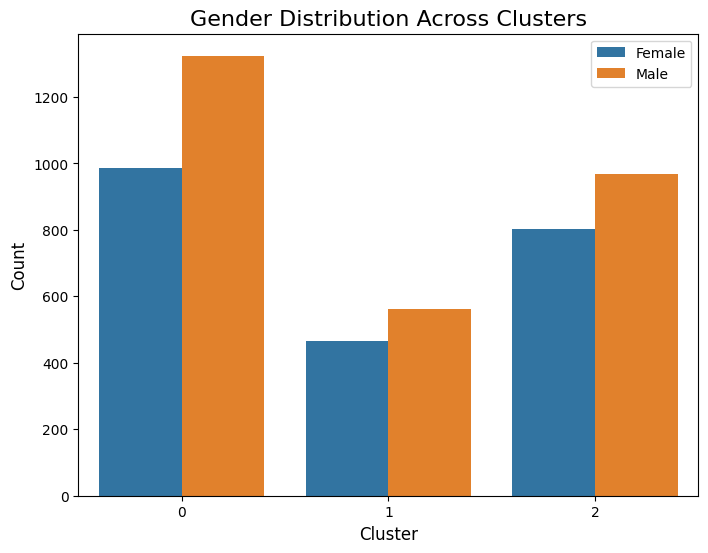

In [239]:
# bar plot for gender
plt.figure(figsize=(8, 6))
sns.countplot(x='Cluster', hue='M', data=chosen_cluster)

plt.title('Gender Distribution Across Clusters', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.legend(labels=['Female','Male'])
plt.show()

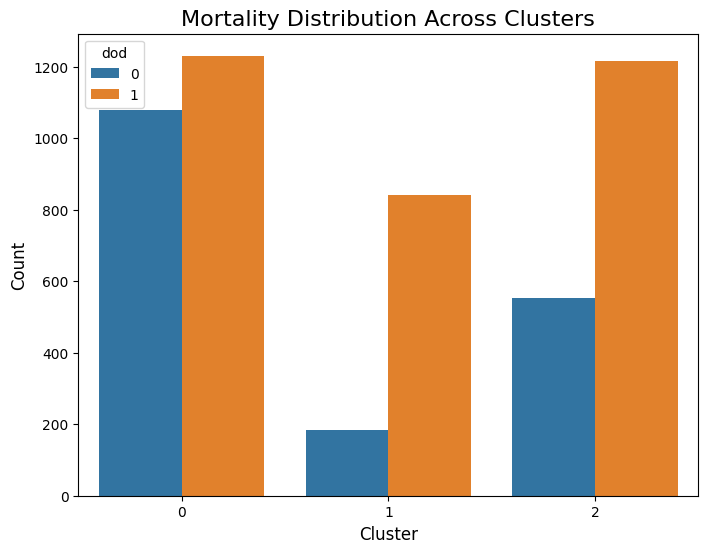

In [240]:
# bar plot for mortality rates
plt.figure(figsize=(8, 6))
sns.countplot(x='Cluster', hue='dod', data=chosen_cluster)

plt.title('Mortality Distribution Across Clusters', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

## Answer to Question 2

When there are 2 clusters, there is a significant drop in the intra-cluster distance, which could suggest that 2 clusters can capture major patterns in the data. In addition, 3 clusters were also chosen for investigation as after 2 clusters, the intra-cluster distance continues to decrease, but the rate of decrease has slowed down. Three clusters were chosen to investigate whether additional clusters past the initial two groups show subtle patterns within subgroups.

Preliminary investigations of the clusters also show that with two clusters, the groups are very biased towards cluster 1(226,943 patients) compared to cluster 2 (107,769). Cluster 1 had more than twice the patients of cluster 2. In comparison, using three clusters showed a even spread between the first and third cluster (having 147,570 and 121,800 patients respectively). However, the second cluster only has 65,342 records, significantly less than the other two.

Using PCA analysis on both 2 and 3 clusters shows that having 2 clusters cover most of the records, indicating that it captures two distinct subgroups. The centroids are also far apart, suggesting that the groups are fairly separated. On 3 clusters, the division along PC1 is slightly less defined, with some points overlapping with other clusters. This can also be seen in the silhouette scores (0.46 and 0.31 for 2 and 3 clusters respectively).

Overall, cluster 3, while it may have less separation with other clusters, still seems to add indicate the presence of a third significant subgroup due to how the second cluster still has a significant amount of records. As such, the inclusion of this cluster could suggest important patterns in the data for patients with hypotension. Additional granularity could also be important in identifying subgroups of patients and so, 3 clusters will be chosen for further analysis.

# Question 3

In [241]:
print(data_km3.info())

data_km3.groupby('Cluster').describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5106 entries, 0 to 5105
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   anchor_age                  5106 non-null   int64  
 1   dod                         5106 non-null   int64  
 2   apsiii                      5106 non-null   int64  
 3   LoS                         5106 non-null   float64
 4   charlson_comorbidity_index  5106 non-null   int64  
 5   M                           5106 non-null   bool   
 6   Cluster                     5106 non-null   int32  
dtypes: bool(1), float64(1), int32(1), int64(4)
memory usage: 224.5 KB
None


anchor_age                                                          \
             count unique top freq       mean        std   min   25%   50%   
Cluster                                                                      
0           2310.0    NaN NaN  NaN  63.883117  14.922007  18.0  55.0  65.0   
1           1026.0    NaN NaN  NaN  63.686160  16.146251  19.0  54.0  65.0   
2           1770.0    NaN NaN  NaN  68.813559  14.556734  18.0  60.0  71.0   

                        dod                                                \
          75%   max   count unique top freq      mean       std  min  25%   
Cluster                                                                     
0        75.0  91.0  2310.0    NaN NaN  NaN  0.532900  0.499024  0.0  0.0   
1        76.0  91.0  1026.0    NaN NaN  NaN  0.820663  0.383822  0.0  1.0   
2        80.0  91.0  1770.0    NaN NaN  NaN  0.687571  0.463615  0.0  0.0   

                        apsiii                                               \
         50%  75%  max   count unique top freq        mean        std   min   
Cluster                                                                       
0        1.0  1.0  1.0  2310.0    NaN NaN  NaN   36.223810   9.143088   3.0   
1        1.0  1.0  1.0  1026.0    NaN NaN  NaN  106.370370  17.430426  80.0   
2        1.0  1.0  1.0  1770.0    NaN NaN  NaN   65.058192  10.385639  44.0   

                                       LoS                             \
          25%    50%    75%    max   count unique top freq       mean   
Cluster                                                                 
0        30.0   37.0   43.0   58.0  2310.0    NaN NaN  NaN   5.211883   
1        93.0  102.0  115.0  189.0  1026.0    NaN NaN  NaN  10.088938   
2        56.0   64.0   73.0   89.0  1770.0    NaN NaN  NaN   7.697876   

                                                     \
               std   min   25%   50%    75%     max   
Cluster                                               
0         6.710169  0.04  1.63  2.96   6.04   86.83   
1        10.467646  0.17  2.83  7.04  13.41   79.08   
2         8.530213  0.21  2.50  4.96   9.83  103.50   

        charlson_comorbidity_index                                           \
                             count unique top freq      mean       std  min   
Cluster                                                                       
0                           2310.0    NaN NaN  NaN  4.709957  2.375316  0.0   
1                           1026.0    NaN NaN  NaN  5.583821  2.825544  0.0   
2                           1770.0    NaN NaN  NaN  5.666102  2.560701  0.0   

                                 M                                         \
         25%  50%  75%   max count unique   top  freq mean  std  min  25%   
Cluster                                                                     
0        3.0  5.0  6.0  14.0  2310      2  True  1324  NaN  NaN  NaN  NaN   
1        4.0  5.0  7.0  16.0  1026      2  True   561  NaN  NaN  NaN  NaN   
2        4.0  5.0  7.0  19.0  1770      2  True   968  NaN  NaN  NaN  NaN   

                        
         50%  75%  max  
Cluster                 
0        NaN  NaN  NaN  
1        NaN  NaN  NaN  
2        NaN  NaN  NaN

## Answer to Question 3 (Using Visualizations from the Question 2 Section)


The main property difference between the three clusters is that the second cluster has the highest rate of mortality, while the third cluster has the second highest rate of mortality. The patients in the second cluster seems to have the most severe outcomes.

This is reflected in both the apsiii and lengths of stay. Records in the second cluster generally have a significantly higher apsiii than the other two clusters. The third cluster also has the second highest mean apsiii. A higher apsiii score indicates higher severity, supporting how the second cluster contains patterns for patients with severe outcomes. 

The lengths of stay also slightly reflect patient outcomes. Patients in the second cluster has higher mean lengths of stay than other clusters. The first cluster has the shortest lengths of stay among all the clusters. When comparing the maximum lengths of stay for each cluster, cluster two has the lowest maximum stay. As mentioned before, higher severity may not always reflect higher lengths of stay as patients may have passed away after a short time of being admitted to the hospital. 

The Charlson comorbidity index does not vary much among every cluster. The second and third clusters have similar comorbidity indexes, while the first cluster is slightly lower. However, they are still similar. This may indicate that comorbidity does not significantly predict mortality. 

Finally, patients in the first and second cluster generally have younger ages, while patients in the third cluster are generally older. This seems to suggest that age does not significantly correlate with mortality rates, as the first and second clusters have similar age groups, but have vastly different mortality rates.

Overall, the second cluster appears to contain the patients with high mortality rates, and apsiii scores appear to correlate the strongest with patient outcomes for profound hypotension.